In [25]:
import os
os.environ["HSA_OVERRIDE_GFX_VERSION"] = "11.0.0"

import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Num GPUs Available:  0


In [26]:
class AdaptiveBasisLayer(tf.keras.layers.Layer):
    def __init__(self, units=32, activation='tanh', **kwargs):
        super(AdaptiveBasisLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Initialize weights and biases
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        # Compute the adaptive basis transformation
        return self.activation(tf.matmul(inputs, self.w) + self.b)

# Define the full PINN model with adaptive basis
class ABUPINN(tf.keras.Model):
    def __init__(self, layers=[(32, "tanh"), (32, "tanh"), (32, "tanh")]):
        super(ABUPINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dropout(rate=0.2)]
        for units, activation in layers:
            self.hidden_layers.append(AdaptiveBasisLayer(units=units, activation=activation))
        self.output_layer = tf.keras.layers.Dense(3)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output

In [27]:
Lx = 10.0
Ly = 1.0
T = 1.0
nu = 0.01

barrier_Lx = 0.3
barrier_Ly = 0.3

barrier_x = 1
barrier_y = Ly / 2 - barrier_Ly / 2

In [28]:

model = ABUPINN(layers=[(32, "tanh"), (32, "relu"), (32, "tanh")])


# Define the PDE residual
def compute_pde_residual(xyt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xyt)
        up = model(xyt)
        u, v, p = up[:, 0], up[:, 1], up[:, 2]
        
        # First derivatives
        u_x = tape.gradient(u, xyt)[:, 0]
        u_y = tape.gradient(u, xyt)[:, 1]
        u_t = tape.gradient(u, xyt)[:, 2]
        v_x = tape.gradient(v, xyt)[:, 0]
        v_y = tape.gradient(v, xyt)[:, 1]
        v_t = tape.gradient(v, xyt)[:, 2]
        p_x = tape.gradient(p, xyt)[:, 0]
        p_y = tape.gradient(p, xyt)[:, 1]
        
        # Second derivatives
        u_xx = tape.gradient(u_x, xyt)[:, 0]
        u_yy = tape.gradient(u_y, xyt)[:, 1]
        v_xx = tape.gradient(v_x, xyt)[:, 0]
        v_yy = tape.gradient(v_y, xyt)[:, 1]
    
    # Continuity equation
    continuity = u_x + v_y
    
    # Momentum equations
    momentum_x = u_t + u*u_x + v*u_y + p_x - nu*(u_xx + u_yy)
    momentum_y = v_t + u*v_x + v*v_y + p_y - nu*(v_xx + v_yy)
    
    del tape
    
    return continuity, momentum_x, momentum_y

# Boundary conditions
def boundary_conditions():
    # careful, hard coded points count
    xys = generate_bc_data(num_points)
    
    bottom_bc, left_bc, top_bc, right_bc = xys

    bottom_predict = model(bottom_bc)
    left_predict = model(left_bc)
    top_predict = model(top_bc)
    right_predict = model(right_bc)
    
    # inflow
    u, v, p = left_predict[:, 0], left_predict[:, 1], left_predict[:, 2]
    bc_loss = tf.reduce_mean(tf.square(u - 1 * (Ly / 2 - tf.pow(0.5 - left_bc[:, 1] / Ly, 2))))

    # outflow
    u, v, p = right_predict[:, 0], right_predict[:, 1], right_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(p))

    for wall in [bottom_predict, top_predict]:
        u, v, p = wall[:, 0], wall[:, 1], wall[:, 2]
        bc_loss += 1000 * tf.reduce_mean(tf.square(u) + tf.square(v))
    return bc_loss

# Boundary conditions
def boundary_conditions_barrier():
    # careful, hard coded points count
    xys = generate_bc_barrier_data(num_points)
    
    bottom_bc, left_bc, top_bc, right_bc, inside_bc = xys

    bottom_predict = model(bottom_bc)
    left_predict = model(left_bc)
    top_predict = model(top_bc)
    right_predict = model(right_bc)
    inside_predict = model(inside_bc)
    
    u, v, p = inside_predict[:, 0], inside_predict[:, 1], inside_predict[:, 2]
    bc_loss = tf.reduce_mean(tf.square(u) + tf.square(v) + tf.square(p))

    u, v, p = bottom_predict[:, 0], bottom_predict[:, 1], bottom_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(u) + tf.square(v))
    u, v, p = left_predict[:, 0], left_predict[:, 1], left_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(u) + tf.square(v))
    u, v, p = right_predict[:, 0], right_predict[:, 1], right_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(u) + tf.square(v))
    u, v, p = top_predict[:, 0], top_predict[:, 1], top_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(u) + tf.square(v))
    return bc_loss

# Training data
def generate_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)
    t = np.random.uniform(0, T, num_points)
    xyt = np.stack([x, y, t], axis=-1)
    return tf.convert_to_tensor(xyt, dtype=tf.float32)

def generate_bc_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)
    t = np.random.uniform(0, T, num_points)

    bottom = np.zeros(num_points)
    left = np.zeros(num_points)
    top = Ly * np.ones(num_points)
    right = Lx * np.ones(num_points)

    bottom_bc = np.stack([x, bottom, t], axis=-1)
    left_bc = np.stack([left, y, t], axis=-1)
    top_bc = np.stack([x, top, t], axis=-1)
    right_bc = np.stack([right, y, t], axis=-1)
    
    return (
        tf.convert_to_tensor(bottom_bc, dtype=tf.float32), 
        tf.convert_to_tensor(left_bc, dtype=tf.float32), 
        tf.convert_to_tensor(top_bc, dtype=tf.float32), 
        tf.convert_to_tensor(right_bc, dtype=tf.float32)
        )
    
def generate_bc_barrier_data(num_points):
    x = np.random.uniform(barrier_x, barrier_x + barrier_Lx, num_points)
    y = np.random.uniform(barrier_y, barrier_y + barrier_Ly, num_points)
    t = np.random.uniform(0, T, num_points)

    bottom = barrier_y * np.ones(num_points)
    left = barrier_x * np.ones(num_points)
    top = (barrier_y + barrier_Ly) * np.ones(num_points)
    right = (barrier_x + barrier_Lx) * np.ones(num_points)

    bottom_bc = np.stack([x, bottom, t], axis=-1)
    left_bc = np.stack([left, y, t], axis=-1)
    top_bc = np.stack([x, top, t], axis=-1)
    right_bc = np.stack([right, y, t], axis=-1)
    inside_bc = np.stack([x, y, t], axis=-1)
    
    return (
        tf.convert_to_tensor(bottom_bc, dtype=tf.float32), 
        tf.convert_to_tensor(left_bc, dtype=tf.float32), 
        tf.convert_to_tensor(top_bc, dtype=tf.float32), 
        tf.convert_to_tensor(right_bc, dtype=tf.float32), 
        tf.convert_to_tensor(inside_bc, dtype=tf.float32)
        )

# Loss function
def loss_function(xy):
    continuity, momentum_x, momentum_y = compute_pde_residual(xy)
    pde_loss = tf.reduce_mean(tf.square(continuity)) + \
               tf.reduce_mean(tf.square(momentum_x)) + \
               tf.reduce_mean(tf.square(momentum_y))
    bc_loss = boundary_conditions()
    bc_barrier_loss = boundary_conditions_barrier()
    return pde_loss, bc_loss, bc_barrier_loss

# Optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Training loop
num_epochs = 10000
num_points = 10000
try:
    for epoch in range(num_epochs):
        xyt = generate_data(num_points)
        with tf.GradientTape() as tape:
            pde_loss, bc_loss, bc_barrier_loss = loss_function(xyt)
            loss = pde_loss + bc_loss + bc_barrier_loss
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss.numpy()}\n'
                f'PDE Loss: {pde_loss}\n'
                f'BC Loss: {bc_loss}\n'
                f'BC Barrier Loss: {bc_barrier_loss}')
    print("Training completed.")
except KeyboardInterrupt as e:
    print(f"Training was interrupted on epoch {epoch}")
    print(f'Epoch {epoch}, Total Loss: {loss.numpy()}\n'
          f'PDE Loss: {pde_loss}\n'
          f'BC Loss: {bc_loss}\n'
          f'BC Barrier Loss: {bc_barrier_loss}')

# model.save('models/2D_time_fluid_with_barrier.keras')


Epoch 0, Total Loss: 3404.77880859375
PDE Loss: 0.25187915563583374
BC Loss: 3402.03466796875
BC Barrier Loss: 2.4922468662261963
Epoch 100, Total Loss: 22.894453048706055
PDE Loss: 0.025433387607336044
BC Loss: 22.844470977783203
BC Barrier Loss: 0.024549013003706932
Epoch 200, Total Loss: 9.346549034118652
PDE Loss: 0.009739130735397339
BC Loss: 9.327120780944824
BC Barrier Loss: 0.009688885882496834
Epoch 300, Total Loss: 11.882760047912598
PDE Loss: 0.005093771498650312
BC Loss: 11.864861488342285
BC Barrier Loss: 0.012805442325770855
Epoch 400, Total Loss: 2.8852999210357666
PDE Loss: 0.00477308826521039
BC Loss: 2.878135919570923
BC Barrier Loss: 0.0023908265866339207
Epoch 500, Total Loss: 4.770230770111084
PDE Loss: 0.004139173775911331
BC Loss: 4.762847900390625
BC Barrier Loss: 0.003244074760004878
Epoch 600, Total Loss: 6.633448123931885
PDE Loss: 0.0026700380258262157
BC Loss: 6.6208720207214355
BC Barrier Loss: 0.00990648940205574
Epoch 700, Total Loss: 1.3961372375488281


In [29]:
# model = tf.keras.models.load_model('models/2D_time_fluid_with_barrier.keras')

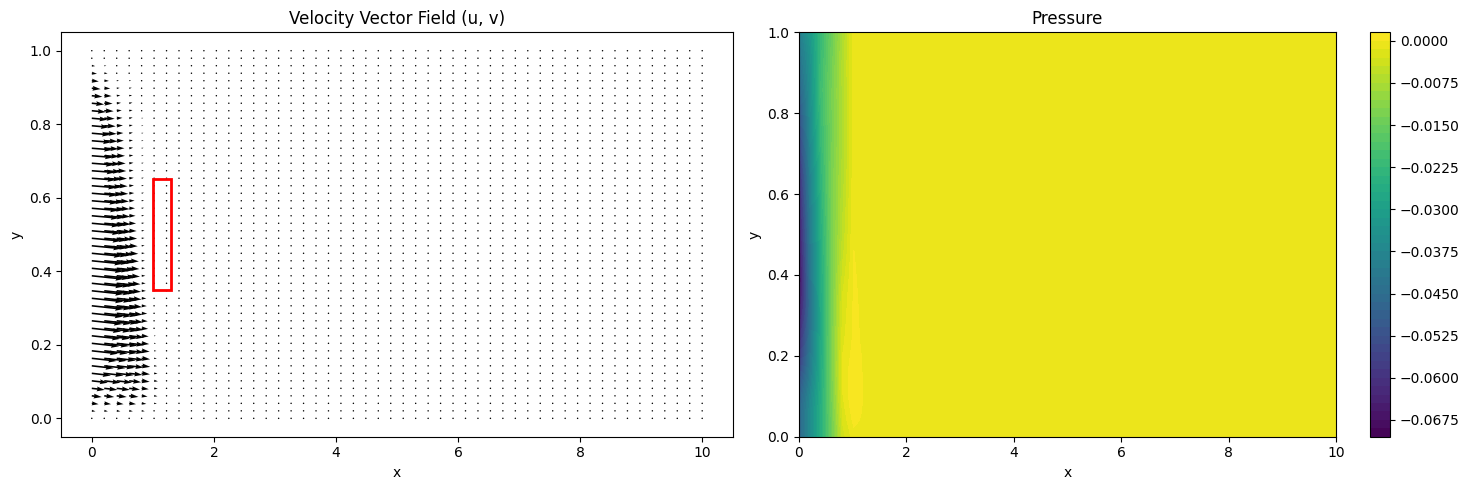

In [33]:
# Visualization
# Generate a grid over the domain
nx, ny, nt = 50, 50, 50
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
t = np.linspace(0, T, nt)
X, Y, T_grid = np.meshgrid(x, y, t)
XYT = np.stack([X.flatten(), Y.flatten(), T_grid.flatten()], axis=-1)
XYT_tensor = tf.convert_to_tensor(XYT, dtype=tf.float32)


X, Y = np.meshgrid(x, y)

predictions = model(XYT_tensor).numpy()
U = predictions[:, 0].reshape((nt, ny, nx))
V = predictions[:, 1].reshape((nt, ny, nx))
P = predictions[:, 2].reshape((nt, ny, nx))


barrier = Rectangle((barrier_x, barrier_y), barrier_Lx, barrier_Ly, edgecolor='red', facecolor='none', linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

i = 49

axs[0].quiver(X, Y, U[:, :, i], V[:, :, i], scale=1., scale_units='xy')
axs[0].add_patch(barrier)
axs[0].set_title('Velocity Vector Field (u, v)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

c3 = axs[1].contourf(X, Y, P[:, :, i], levels=50, cmap='viridis')
# axs[1].add_patch(barrier)
axs[1].set_title('Pressure')
fig.colorbar(c3, ax=axs[1])
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [31]:
print(X.shape)

(50, 50)
